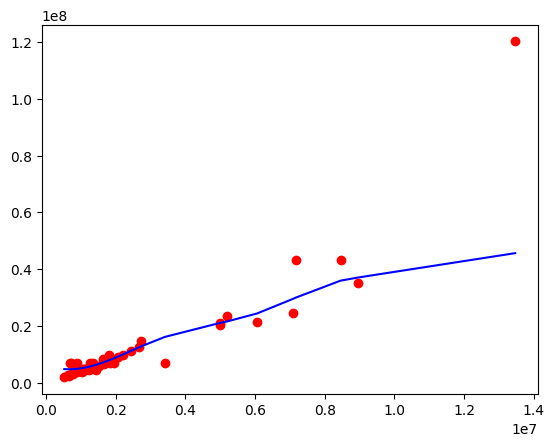

/tmp/ipython-input-1186117109.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_grid = np.arange(min(sc_X.inverse_transform(X)), max(sc_X.inverse_transform(X)), 10)


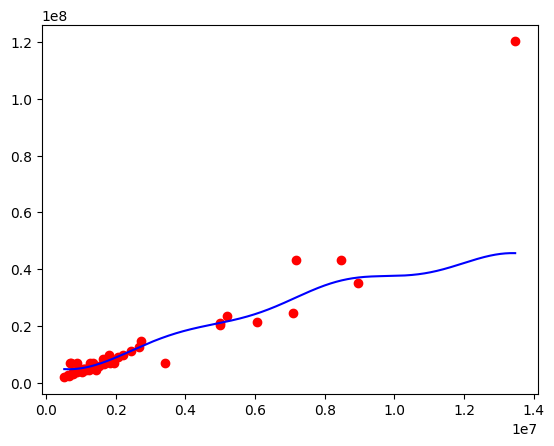

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

dt = pd.read_csv('pref_population_gdp.csv', thousands=',')
#thousands=','は数値の桁区切り” として使われている記号を省くことができる機能
X = dt.iloc[:, 1:-1].values
y = dt.iloc[:, -1].values
y = y.reshape(-1,1)

from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')
y = imputer.fit_transform(y)

from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
sc_y = StandardScaler()
X = sc_X.fit_transform(X)
y = sc_y.fit_transform(y)

from sklearn.svm import SVR
reg = SVR(kernel = 'rbf')
reg.fit(X, y.ravel())

sc_y.inverse_transform(reg.predict(sc_X.transform([[6.5]])).reshape(1,-1))

plt.scatter(sc_X.inverse_transform(X), sc_y.inverse_transform(y.reshape(-1,1)), color = 'red')
#X = sc_X.fit_transform(X)➡スケーリングを元に戻す処理（逆変換）
plt.plot(sc_X.inverse_transform(X), sc_y.inverse_transform(reg.predict(X).reshape(-1,1)), color = 'blue')
#↓参照
plt.show()

X_grid = np.arange(min(sc_X.inverse_transform(X)), max(sc_X.inverse_transform(X)), 10)
#最小の人口から最大の人口まで、10ずつ増やして並べる
X_grid = X_grid.reshape((len(X_grid), 1))
#SVR や scaler が 2次元配列しか受け取れないからX_grid を「縦に並んだ1列のデータ」にする
plt.scatter(sc_X.inverse_transform(X), sc_y.inverse_transform(y), color = 'red')
plt.plot(X_grid.reshape(-1,1), sc_y.inverse_transform(reg.predict(sc_X.transform(X_grid)).reshape(-1,1)), color = 'blue')
plt.show()


sc_y.inverse_transform(
    reg.predict(
        sc_X.transform([[6.5]])
    ).reshape(1, -1)
)

一言でいうと…

「6.5 を使って SVR モデルに予測させた結果を、
　スケーリング前の“もとの値”に戻す処理」

① sc_X.transform([[6.5]])
👉 入力の「6.5」を“学習時と同じスケール”に変換

SVR は **標準化（スケーリング）**された数字でしか学習しない。

だから、予測するときも 数字を同じスケールに変換する必要がある。

例えると：

学習時：身長を「平均0、標準偏差1」に変換した世界で学んだ

予測時も：その世界の単位に合わせて身長を変換しないといけないというイメージ。

② regressor.predict( … )
👉 SVR がスケールされた数字をもとに y（GDPなど）を予測

ここでの結果は “スケールされた世界の予測値” で、
本物のGDPの値ではない。

たとえばこんな値が出る：

0.82
-0.45
1.23


→ これはまだ「標準化された予測値」。

③ .reshape(1, -1)
👉 予測値を “inverse_transform 用の形” に整える

inverse_transform() は 2次元の形 しか受け付けない。

だから：

0.82


のような1次元を

[[0.82]]


の形に変える必要がある。

④ sc_y.inverse_transform( … )
👉 スケーリングされた予測値を “もとの値（本物のGDP）” に戻す

標準化された値を、学習前のスケールに戻す。

例：

学習中（スケール後） → 0.82

元の世界の GDP → 7450.3 など本物の数字に戻る

これを 逆変換（inverse transform） という。

例えると…

あなたは「身長を cm→m」に変換して走るロボットを訓練したとする。

訓練：身長 160cm → 1.60m で覚えた

予測：身長 170cm の人を予測したいとき

そのまま 170cm 入れちゃダメ！

→ 1.70m に変換してロボットに渡す必要がある。

ロボット（SVR）は「m の世界」で学んでいるから。

そして結果が m で返ってきたら cm に戻す必要がある。



sc_y.inverse_transform(reg.predict(X).reshape(-1,1))

① reg.predict(X)
👉 SVRが“スケーリングされた世界”で予測した y の値

例えると：

元の y（GDP）が 5000、6000、7000 のような“普通の世界の数字”

でも学習した X・y は 標準化された世界の数字

だから予測結果も：

[ 0.82 ]
[-1.12 ]
[ 0.45 ]


みたいな 標準化後の値で出てくる。

② .reshape(-1, 1)
👉 inverse_transform が受け取れる形（2次元）に整える

inverse_transform()は必ず2次元の形を要求する。

NG: [0.82, -1.12, 0.45] ← 1次元

OK: [[0.82], [-1.12], [0.45]] ← 2次元

なので：

reg.predict(X) → 1次元の予測結果
reg.predict(X).reshape(-1,1) → 2次元の形に変換


これが reshape の役割。

③ sc_y.inverse_transform( … )
👉 標準化された予測値を “元の世界の値（本物のGDP）” に戻す

ここが一番大事。

SVRは 標準化された世界の数値で学ぶモデル。

だから予測値も標準化されている。

これを sc_y.inverse_transform() することで…

0.82 → 6541.7
-1.12 → 3120.5
0.45 → 5120.0


のように 元の世界のGDPの値に戻る。

